**Goal**: Build a model to predict the difference in hourly payment, based on the size and the industry of the company. 

We will examine linear regression & decision trees. 

In [1]:
# Import all data libraries

import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

## Import all Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Other import
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection


### Prepare the data

In [2]:
# Load files

# UK paygap data
gap = pd.read_csv('paygap_v2.csv')

In [3]:
gap.head(2)

,Unnamed: 0,EmployerName,DiffMedianHourlyPercent,DiffMedianBonusPercent,MaleBonusPercent,FemaleBonusPercent,MaleLowerQuartile,FemaleLowerQuartile,MaleTopQuartile,FemaleTopQuartile,CompanyLinkToGPGInfo,EmployerSize,RegAddress.PostTown,CompanyCategory,SICCode.SicText_1,EmployerSizeCenter,SIC_SECTOR
0,0,"""Bryanston School"",Incorporated",28.2,0.0,0.0,0.0,24.4,75.6,51.5,48.5,https://www.bryanston.co.uk/employment,500 to 999,DORSET,"PRI/LTD BY GUAR/NSC (Private, limited by guara...",85310 - General secondary education,750.0,Services
1,1,"""RED BAND"" CHEMICAL COMPANY, LIMITED",-2.7,37.5,15.6,66.7,20.3,79.7,18.1,81.9,NaN,250 to 499,EDINBURGH,Private Limited Company,47730 - Dispensing chemist in specialised stores,350.0,Utility Services


In [4]:
# Keep only relevant columns
cols = ['EmployerName', 'DiffMedianHourlyPercent', 'FemaleTopQuartile', 'EmployerSize', 
        'RegAddress.PostTown', 'EmployerSizeCenter', 'SIC_SECTOR' ]

gap = gap[cols]

gap.rename(columns={'EmployerName': 'Employer', 'DiffMedianHourlyPercent': 'HourlyDiff', 
                    'DiffMedianHourlyPercent': 'HourlyDiff', 
                   'RegAddress.PostTown': 'Town',
                   'EmployerSizeCenter': 'MedianSize',
                   'SIC_SECTOR': 'Sector'}, inplace=True)

# Drop nulls from MedianSize

gap = gap.dropna(subset = ['MedianSize'])
gap = gap.dropna(subset = ['Sector'])


print(len(gap))
gap.head(2)


8264


,Employer,HourlyDiff,FemaleTopQuartile,EmployerSize,Town,MedianSize,Sector
0,"""Bryanston School"",Incorporated",28.2,48.5,500 to 999,DORSET,750.0,Services
1,"""RED BAND"" CHEMICAL COMPANY, LIMITED",-2.7,81.9,250 to 499,EDINBURGH,350.0,Utility Services


In [5]:
gap['HourlyDiff'].isnull().values.sum()

0

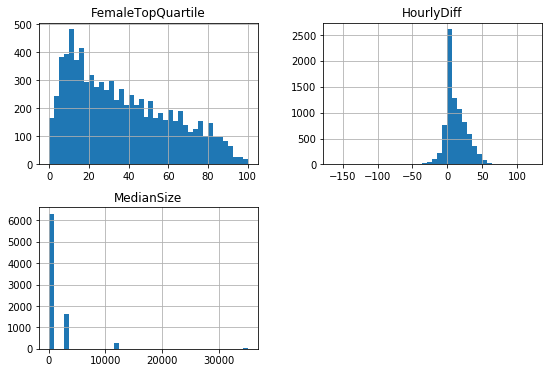

In [6]:
#Looking for relationships

gap.hist(bins = 40, figsize = (9, 6));

In [7]:
gap['HourlyDiff'].max()

121.2

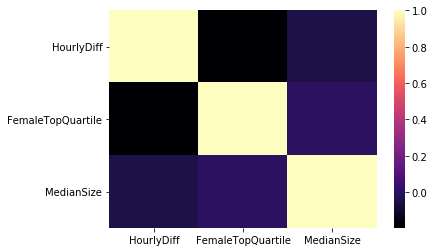

In [8]:
corr_mat = gap.corr()
plt.figure()
sns.heatmap(corr_mat, cmap = 'magma')

### Split the dataset

In [43]:
#I kepp all columns as predictor, besides the target column

X = gap.drop(['HourlyDiff'], axis=1) #.values.reshape(-1,1)
y = gap['HourlyDiff']



In [10]:
X_train,X_test, y_train, y_test = train_test_split(X, y) 
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(6198, 6)
(6198,)
(2066, 6)
(2066,)


In [11]:
X_train.head(2)

,Employer,FemaleTopQuartile,EmployerSize,Town,MedianSize,Sector
7462,"ROYAL LONDON MUTUAL INSURANCE SOCIETY,LIMITED(...",30.1,1000 to 4999,NaN,3500.0,Financials
7435,ROYAL AGRICULTURAL UNIVERSITY,33.8,250 to 499,CIRENCESTER,350.0,Services


In [12]:
y_train.head()

7462    28.4
7435     0.0
5046    15.4
41       9.2
3140     0.0
Name: HourlyDiff, dtype: float64

In [13]:
def shape_dummy(X, y):
    train = X.join(y)
    dummies = pd.get_dummies(train['Sector'])
    train = train.join(dummies)

    X = (train
         .drop('HourlyDiff', axis = 1)
         .drop('Employer', axis = 1)
         .drop('EmployerSize', axis = 1)
         .drop('Town', axis = 1)
         .drop('Sector', axis = 1)
         .drop('FemaleTopQuartile', axis = 1))
    y = train['HourlyDiff']

    return X, y

X, y = shape_dummy(X_train, y_train)

### Run linear models

In [14]:
#Instantiate all linear models

lm = LinearRegression()
lasso = Lasso()
ridge = Ridge()
enet = ElasticNet()

In [15]:
def linear_model_metrics_for_algo(algo, X, y):
    predictions = algo.predict(X)
    mse = np.sqrt(mean_squared_error(predictions, y))
    r2 = algo.score(X, y)
    residuals = (y - predictions)
    print('mean squeared error', mse)
    print('R2 Score: ', r2)
    plt.hist(residuals)
    return mse

def get_linear_model_metrics(X, y, algo):
    pvals = feature_selection.f_regression(X, y)[1] #I know that 1 is the p-value on the f_regression function
    algo.fit(X, y)
    linear_model_metrics_for_algo(algo, X, y)
    y_int = algo.intercept_
    coefficients = algo.coef_
    print('Intercept: ', y_int)
    print('Coefficients: ', coefficients)
    print('P-Values: ',pvals)
    return algo

mean squeared error 15.71209809936638
R2 Score:  0.05553500602213213
Intercept:  11.921822024792005
Coefficients:  [-2.16800847e-04  4.50278818e+00 -7.72972656e+00  7.91319574e+00
  8.13693665e-01 -5.03962989e+00 -8.47518341e+00 -4.73560250e+00
 -5.71333137e+00  7.18392445e-01 -2.72805754e-01  1.67260902e+01
  1.29211922e+00]
P-Values:  [1.16201505e-04 2.33069956e-02 6.21420880e-04 7.64491485e-36
 2.76096232e-01 2.78385730e-07 9.32916575e-02 5.58659093e-08
 4.24866506e-20 8.91335896e-02 1.18300547e-01 1.08103739e-09
 6.56046971e-01]


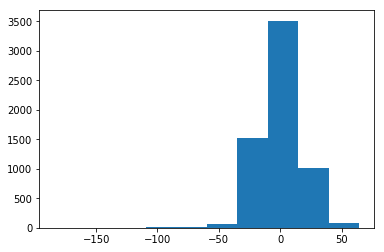

In [16]:
lm_algo = get_linear_model_metrics(X, y, lm)

mean squeared error 16.14807104171002
R2 Score:  0.0023945697687344225
Intercept:  12.232776632774947
Coefficients:  [-0.00022014  0.         -0.          0.          0.         -0.
 -0.         -0.         -0.          0.         -0.          0.
  0.        ]
P-Values:  [1.16201505e-04 2.33069956e-02 6.21420880e-04 7.64491485e-36
 2.76096232e-01 2.78385730e-07 9.32916575e-02 5.58659093e-08
 4.24866506e-20 8.91335896e-02 1.18300547e-01 1.08103739e-09
 6.56046971e-01]


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

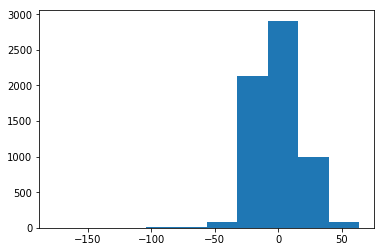

In [17]:
get_linear_model_metrics(X, y, lasso)

mean squeared error 15.712175002918324
R2 Score:  0.055525760548992165
Intercept:  11.95717616550803
Coefficients:  [-2.16437904e-04  4.40500160e+00 -7.61010428e+00  7.86467565e+00
  7.76870225e-01 -5.05350927e+00 -7.73709071e+00 -4.75522988e+00
 -5.73882098e+00  6.82188794e-01 -3.08669818e-01  1.62504501e+01
  1.22423858e+00]
P-Values:  [1.16201505e-04 2.33069956e-02 6.21420880e-04 7.64491485e-36
 2.76096232e-01 2.78385730e-07 9.32916575e-02 5.58659093e-08
 4.24866506e-20 8.91335896e-02 1.18300547e-01 1.08103739e-09
 6.56046971e-01]


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

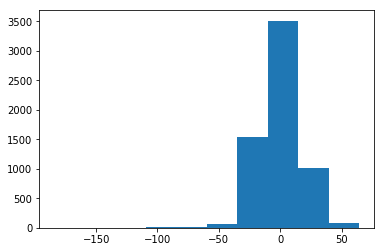

In [18]:
get_linear_model_metrics(X, y, ridge)

mean squeared error 16.125642978666168
R2 Score:  0.005163794594020277
Intercept:  12.1906757532575
Coefficients:  [-2.20086999e-04  0.00000000e+00 -0.00000000e+00  4.53630442e-01
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -4.33609650e-02  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00]
P-Values:  [1.16201505e-04 2.33069956e-02 6.21420880e-04 7.64491485e-36
 2.76096232e-01 2.78385730e-07 9.32916575e-02 5.58659093e-08
 4.24866506e-20 8.91335896e-02 1.18300547e-01 1.08103739e-09
 6.56046971e-01]


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

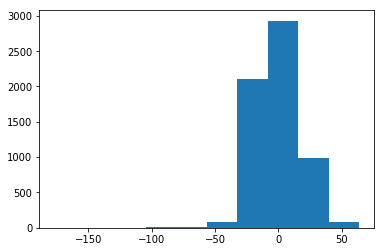

In [19]:
get_linear_model_metrics(X, y, enet)

### Scaling

In [20]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline


In [21]:
pipeline = Pipeline([('std_scaler', StandardScaler()),
                    ('poly_features', PolynomialFeatures(degree = 4))])

In [22]:
x_scaled = pipeline.fit_transform(X)

#### Rerun models after scaling

In [23]:
#Instantiate the models again

lm = LinearRegression()
lasso = Lasso()
ridge = Ridge()
enet = ElasticNet()


/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


mean squeared error 15.629214503133259
R2 Score:  0.06547310389024386
Intercept:  -938355922.6431099
Coefficients:  [-2.80791735e-13  4.66784592e+08 -1.51030168e+08 ...  6.23008976e+06
 -1.45142768e+08 -6.81899429e+08]
P-Values:  [           nan 1.16201505e-04 2.33069956e-02 ... 2.38285455e-06
 6.55876201e-01 6.56046971e-01]


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

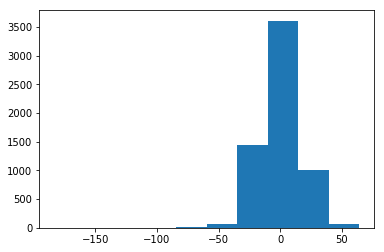

In [24]:
get_linear_model_metrics(x_scaled, y, lm)

/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


mean squeared error 15.693274661295415
R2 Score:  0.05779663002016577
Intercept:  12.26288250137115
Coefficients:  [ 0.         -0.          0.         ... -0.          0.
 -0.00022168]
P-Values:  [           nan 1.16201505e-04 2.33069956e-02 ... 2.38285455e-06
 6.55876201e-01 6.56046971e-01]


/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

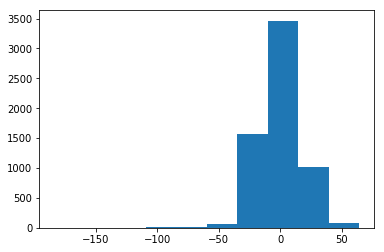

In [25]:
get_linear_model_metrics(x_scaled, y, lasso)

/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


mean squeared error 15.629262242549874
R2 Score:  0.06546739485899855
Intercept:  12.011409306897058
Coefficients:  [ 0.00000000e+00 -3.65344880e-01  3.54735032e-06 ...  3.87316010e-08
 -6.59250043e-07  1.08275937e-04]
P-Values:  [           nan 1.16201505e-04 2.33069956e-02 ... 2.38285455e-06
 6.55876201e-01 6.56046971e-01]


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

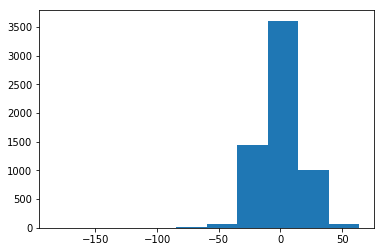

In [26]:
get_linear_model_metrics(x_scaled, y, ridge)

/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


mean squeared error 15.682248192977765
R2 Score:  0.059120193902271745
Intercept:  12.30548960875063
Coefficients:  [ 0.         -0.          0.         ... -0.          0.
 -0.00022742]
P-Values:  [           nan 1.16201505e-04 2.33069956e-02 ... 2.38285455e-06
 6.55876201e-01 6.56046971e-01]


/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

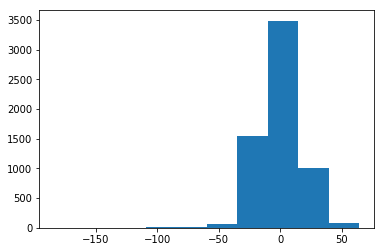

In [27]:
get_linear_model_metrics(x_scaled, y, enet)

Scaling the data didn't improve the results. We will now try regression tree.

### Regression tree

In [28]:
from sklearn.tree import DecisionTreeRegressor


In [29]:
regr = DecisionTreeRegressor(max_depth=3)
regr.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [30]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [31]:
feature_cols = list(X)

In [32]:
X_validate, y_true = shape_dummy(X_test, y_test)


y_pred = regr.predict(X_validate)
y_pred_series = pd.Series(y_pred, index=y_true.index, name='y_pred')

In [33]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_true.as_matrix(), y_pred))

15.61251653683602

In [34]:
depths = []
rmses = []

min_rmse = None
best_model = None

for depth in range(3, 15):
    regr_ = DecisionTreeRegressor(max_depth=depth)
    regr_.fit(X, y)
    y_pred = regr_.predict(X_validate)
    rmse = np.sqrt(mean_squared_error(y_true.as_matrix(), y_pred))

    if min_rmse is None or rmse < min_rmse:
        best_model = regr_
        min_rmse = rmse
    
    depths.append(depth)
    rmses.append(rmse)

In [35]:
# Based on sklearn/tree/export.py ( https://goo.gl/Y5y6et )
from sklearn.tree import _tree
def fix_rmse_recursive(tree, node_id):
    tree.impurity[node_id] = np.sqrt(tree.impurity[node_id])
    
    left_child = tree.children_left[node_id]
    right_child = tree.children_right[node_id]

    if left_child != _tree.TREE_LEAF:
        fix_rmse_recursive(tree, left_child)#, criterion=criterion, parent=node_id, depth=depth + 1)
        fix_rmse_recursive(tree, right_child)#, c, criterion=criterion, parent=node_id, depth=depth + 1)

best_model.criterion = 'rmse'
fix_rmse_recursive(best_model.tree_, 0)

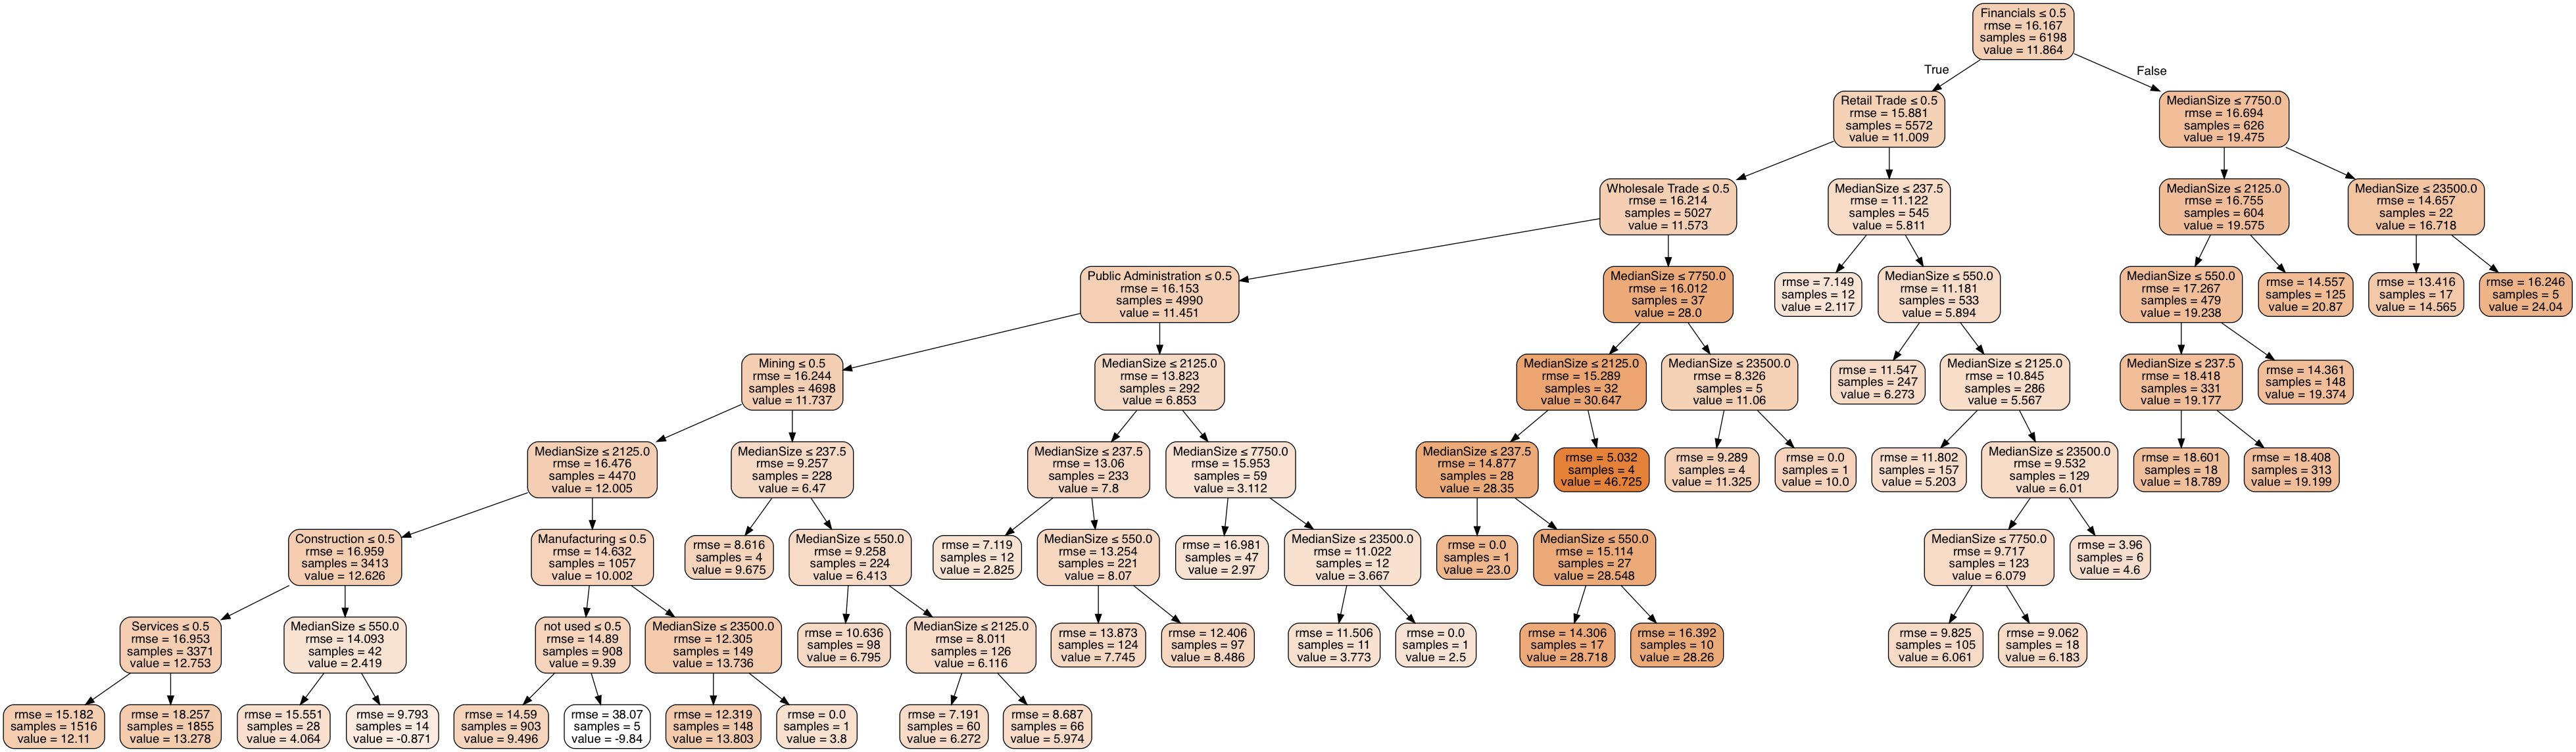

In [36]:
dot_data = StringIO()
export_graphviz(best_model, out_file=dot_data,  filled=True, rounded=True, special_characters=True,
                feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [37]:
y_true.as_matrix()

array([ 33. ,  32. ,  24.8, ..., -19. ,  -9. ,  29.3])

In [38]:
y_pred

array([13.15049505, 13.57398305,  9.03936842, ..., 13.57398305,
       12.02868217, 20.8696    ])

mean squeared error 15.531360799211283
R2 Score:  0.037834241949604386


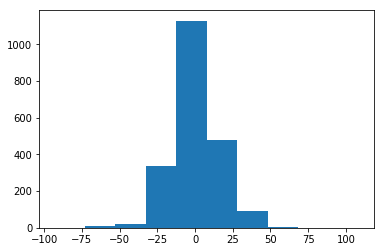

In [39]:
linear_rmse = linear_model_metrics_for_algo(lm_algo, X_validate, y_true)

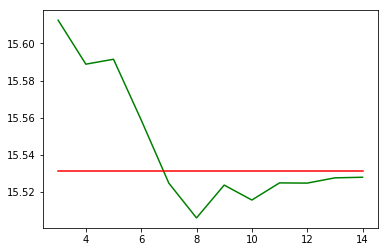

In [40]:
plt.plot(depths, rmses,                         'g-',
         depths, [linear_rmse for i in depths], 'r-')

In [41]:
X_all = gap.drop(['HourlyDiff'], axis=1)
y_all = gap['HourlyDiff']

X_all, y_all = shape_dummy(X_all, y_all)

y_all_pred = best_model.predict(X_all)
y_all_series = pd.Series(y_all_pred, index=y_all.index, name='y_pred')

uniq = X_all.join(y_all_series).drop_duplicates()

dumies = (uniq
          .drop('MedianSize', axis = 1)
          .drop('y_pred', axis = 1))

# https://stackoverflow.com/a/45622556
sector = pd.Series(dumies.idxmax(axis=1), name='Sector')

cols = ['Sector', 'MedianSize', 'y_pred']
uniq[['MedianSize', 'y_pred']].join(sector)[cols].sort_values(['Sector', 'MedianSize'])

,Sector,MedianSize,y_pred
2987,Agriculture,125.0,12.110356
8,Agriculture,350.0,12.110356
373,Agriculture,750.0,12.110356
239,Agriculture,3500.0,9.496013
110,Construction,350.0,4.064286
526,Construction,750.0,-0.871429
911,Construction,3500.0,9.496013
245,Financials,125.0,18.788889
128,Financials,350.0,19.199042
2,Financials,750.0,19.374324


### Note: this is if I want to get predictions for specific rows

In [42]:
lm.predict(x_scaled[:10])

array([20.76656568, 13.21899569, 13.21899569,  5.60317504, 11.83414304,
       11.87386549, 11.44874799, 10.89698637,  8.98639584, 13.21899569])